In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [2]:
!nvidia-smi

Mon May 20 16:52:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**`Torch Dataset` для нашего датасета**

In [3]:
class MedicalImageDataset(Dataset):
    def __init__(self, img_dir, data='train', transform=None):
        super().__init__()
        self.img_dir = img_dir,
        self.data = data
        self.labels = torch.load(f'{img_dir}/{data}/labels.pt')
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx): 
        image = read_image(f'{self.img_dir[0]}/{self.data}/images/image({idx}).jpg') / 255
        if self.transform:
            image = self.transform(image)
            
        return (image, self.labels[idx])

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = MedicalImageDataset(
    img_dir=f'../input',
    data='train',
    transform=preprocess
)

test_dataset = MedicalImageDataset(
    img_dir=f'../input',
    data='test', 
    transform=preprocess
)

**Преобразуем в `Torch Dataloader`, чтобы перемешивать данные и разбивать их на батчи**

In [5]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.float32


**Определяем, на каком устройстве будем обучать нейросеть**

In [6]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


**Функции для обучения и теста нейросети**

In [8]:
def train(dataloader, model, criterion, optimizer, epoch, num_epochs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    len_batch = dataloader.batch_size
    
    clear_output()
    model.train()
    
    loss_avg, accuracy_avg = 0, 0
    pbar = tqdm(dataloader, desc=f'Training {epoch + 1}/{num_epochs}')
    
    for i, (X_batch, y_batch) in enumerate(pbar):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.long())
        accuracy = (predictions.argmax(1) == y_batch).type(torch.float).sum().item()
        loss.backward()
        optimizer.step()
        
        loss_avg += loss.item()
        accuracy_avg += accuracy
        
        pbar.set_postfix({'loss': loss.item(), 'accuracy': f'{100 * accuracy / len_batch:.1f}%'})

    return loss_avg / num_batches, accuracy_avg / size
        
        
def test(dataloader, model, criterion, epoch, num_epochs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    clear_output()
    model.eval()
    
    with torch.no_grad():
        loss_avg, accuracy_avg = 0, 0
        pbar = tqdm(dataloader, desc=f'Testing {epoch + 1}/{num_epochs}')
        
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            predictions = model(X_batch)
            loss_avg += criterion(predictions, y_batch.long()).item()
            accuracy_avg += (predictions.argmax(1) == y_batch).type(torch.float).sum().item()
            
    return loss_avg / num_batches, accuracy_avg / size

### Пробуем готовые архитектуры

**ResNet-50**

In [11]:
from torchvision.models import resnet50, ResNet50_Weights


weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)
model.fc = nn.Linear(2048, 23).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, momentum=0.9)  # , momentum=0.9, weight_decay=0.0005

num_epochs = 30

train_loss, train_accuracy = (np.zeros(num_epochs), np.zeros(num_epochs))
test_loss, test_accuracy = (np.zeros(num_epochs), np.zeros(num_epochs))

for epoch in range(num_epochs):
    train_loss[epoch], train_accuracy[epoch] = train(train_dataloader, model, criterion, optimizer, epoch, num_epochs)
    test_loss[epoch], test_accuracy[epoch] = test(test_dataloader, model, criterion, epoch, num_epochs)

Testing 30/30: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s]


**Строим графики**

In [12]:
# функция для настройки графиков (названия, оси, сетка, шрифт)

def plot_settings(ax, title, xlabel, ylabel):
    font_title = {'family': 'Comic Sans MS', 'color': 'black', 'size': 22}
    font_labels = {'family': 'Times New Roman', 'color': 'black', 'size': 20}
    font_ticks = {'family': 'Times New Roman', 'color': 'black', 'size': 16}
    
    ax.set_xlabel(xlabel, fontdict=font_labels)
    ax.set_ylabel(ylabel, fontdict=font_labels)
    ax.set_xticklabels(ax.get_xticklabels(), fontdict=font_ticks)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict=font_ticks)
    ax.grid(color='gray', linestyle='--', linewidth=0.25)
    ax.set_title(label=title, fontdict=font_title)
    ax.legend()

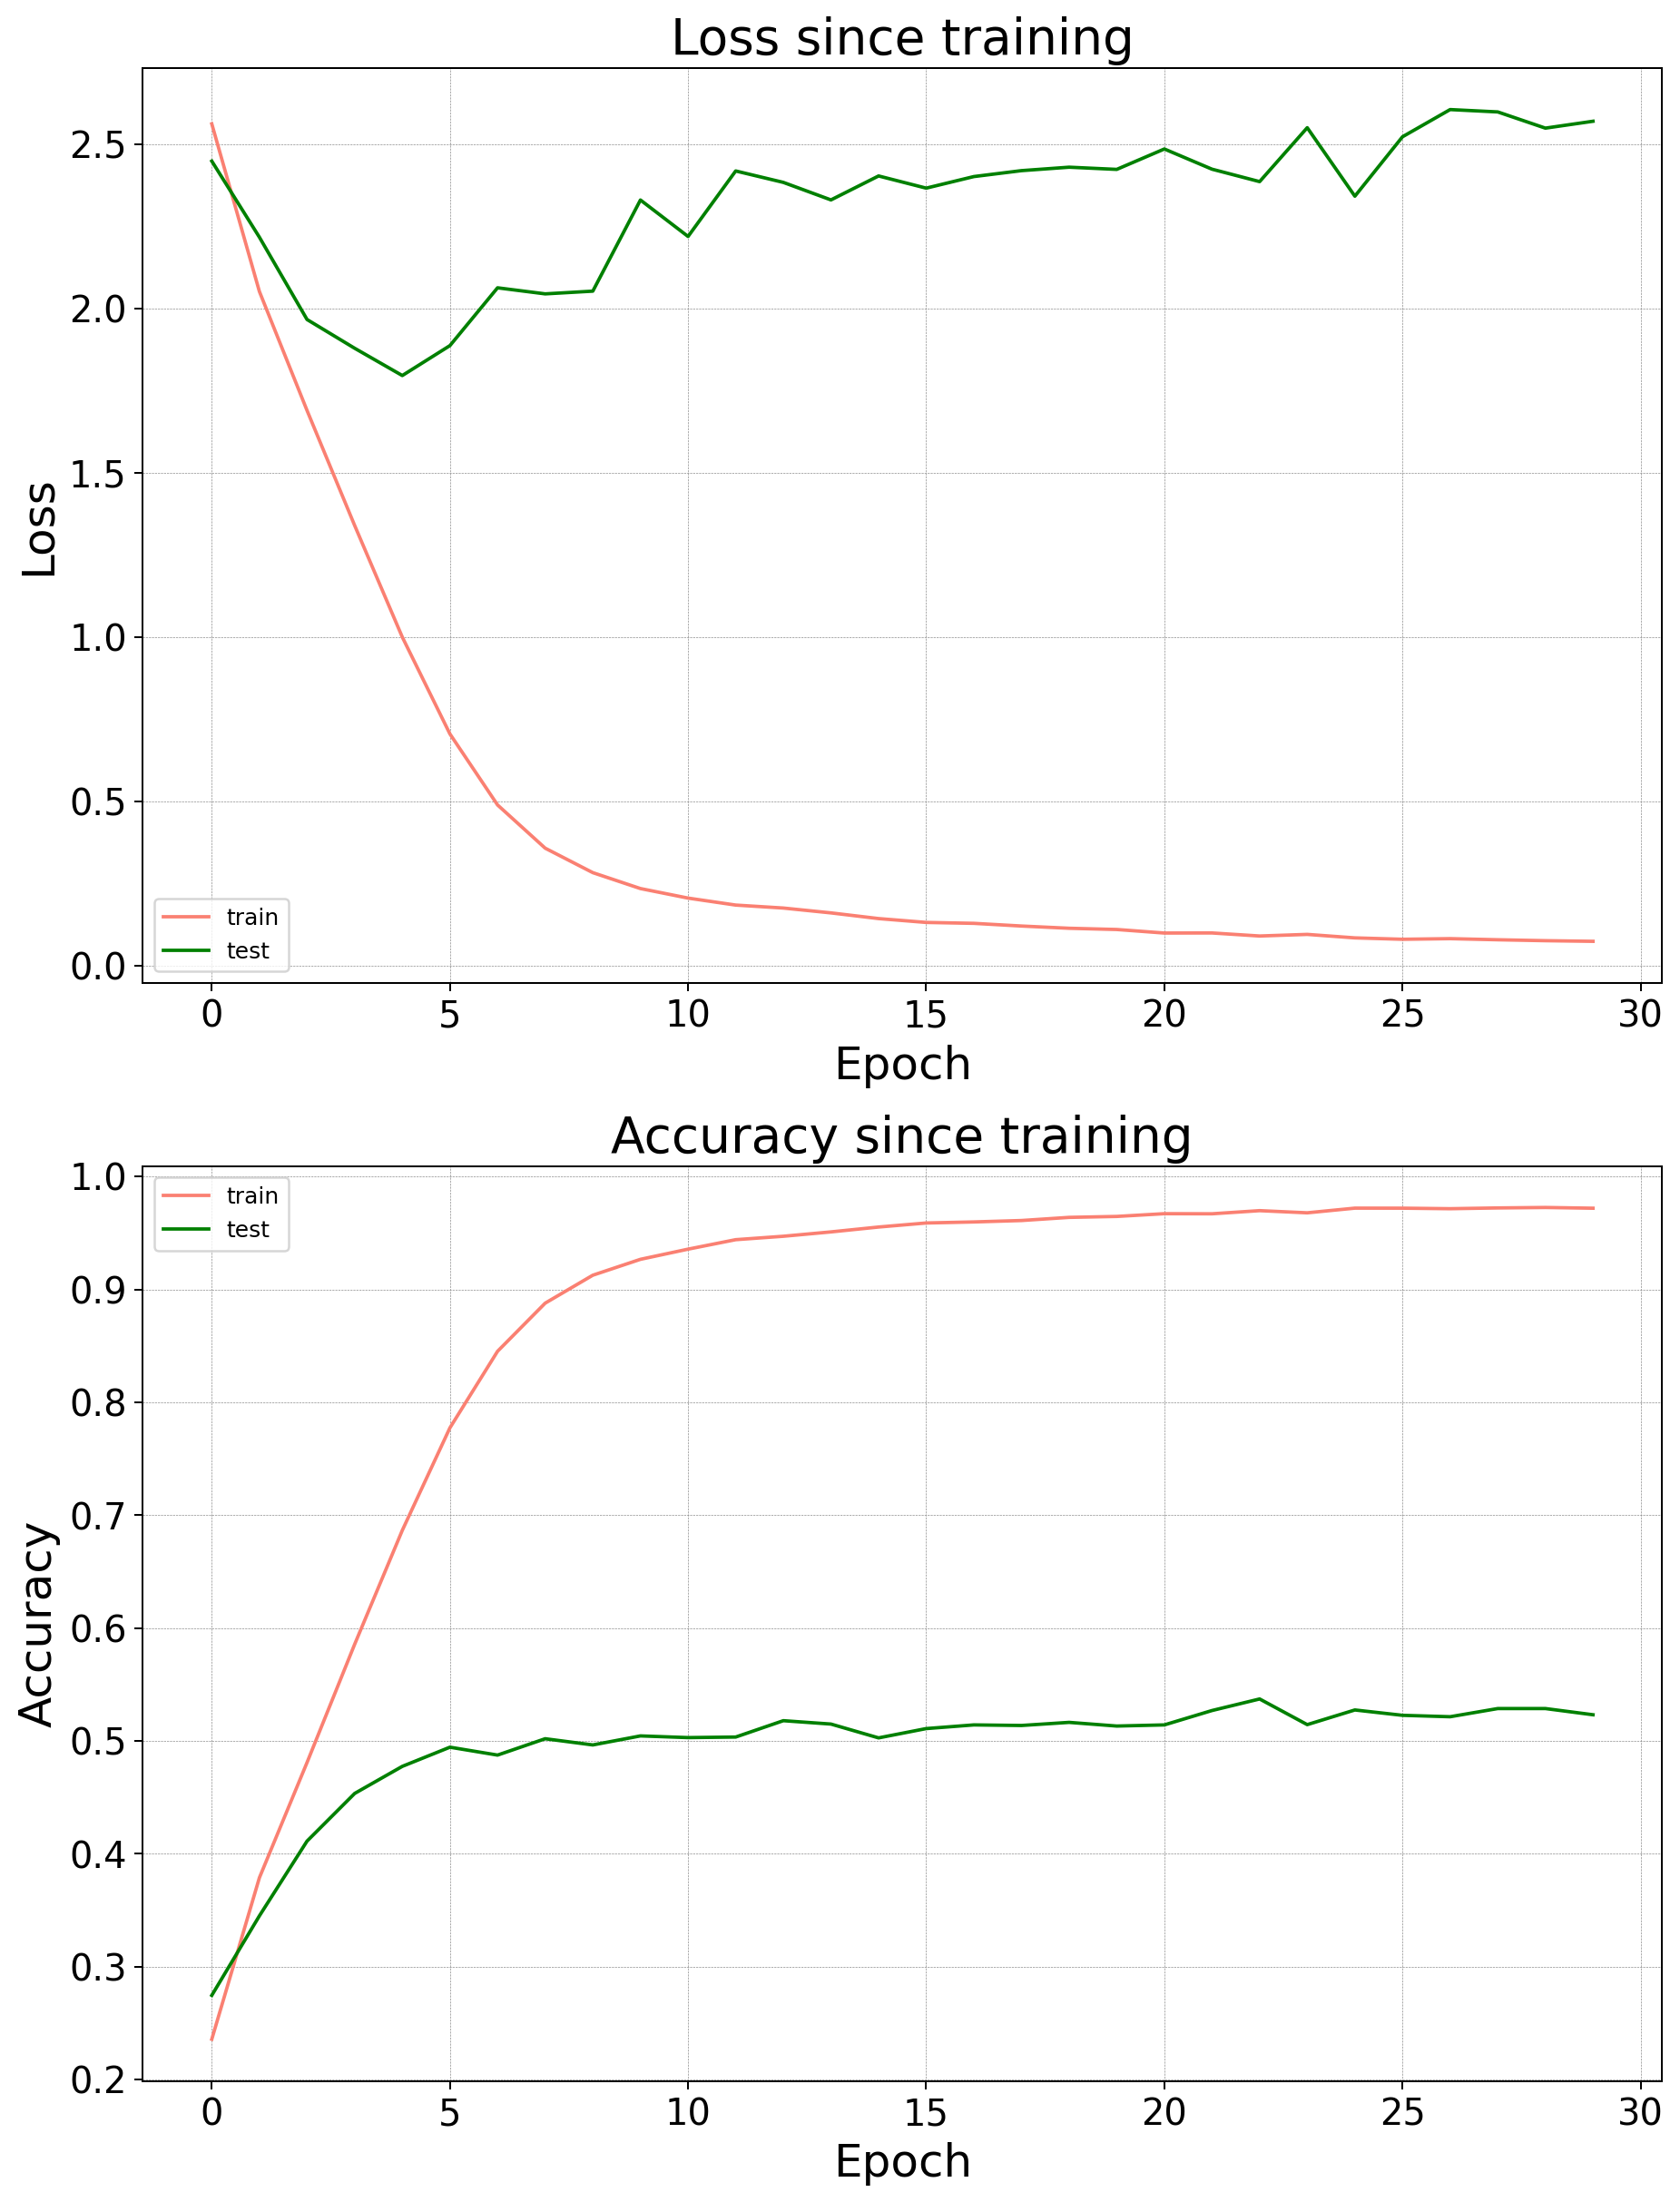

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16), dpi=180)

ax[0].plot(train_loss, color='salmon', label='train')
ax[0].plot(test_loss, color='green', label='test')
plot_settings(ax=ax[0], title='Loss since training', xlabel='Epoch', ylabel='Loss')

ax[1].plot(train_accuracy, color='salmon', label='train')
ax[1].plot(test_accuracy, color='green', label='test')
plot_settings(ax=ax[1], title='Accuracy since training', xlabel='Epoch', ylabel='Accuracy')

plt.show()

**Сохраняем модель**

In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
